<a href="https://colab.research.google.com/github/yd-14/HRNet-fundus-image-segmentation/blob/main/HRNet_mask_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from keras.models import load_model
model_OD = load_model('/content/gdrive/MyDrive/MiniProjectDataset/HRNet_OD_model.h5')
model_OC = load_model('/content/gdrive/MyDrive/MiniProjectDataset/HRNet_OC_model.h5')

In [ ]:
import cv2
import numpy as np

def clahe_image(img):
    img = img.astype('uint8')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lab_image = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab_image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    clahe_lab_image = cv2.merge((cl, a, b))

    final_image = cv2.cvtColor(clahe_lab_image, cv2.COLOR_LAB2RGB)

    final_image = final_image.astype('float32')
    return final_image

def histo_equal(img):
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    equalized_image = cv2.equalizeHist(img)

    final_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    final_image = final_image.astype('float32')
    return final_image

def preprocess_image(img):
    return histo_equal(clahe_image(img))

In [ ]:
def post_process(pred_mask):
  contours, _ = cv2.findContours((pred_mask[0]).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) > 0:
    _, labels, stats, _ = cv2.connectedComponentsWithStats((pred_mask[0]).astype(np.uint8))

    largest_region_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a mask image with only the largest region
    mask = np.zeros_like((pred_mask[0]).astype(np.uint8))
    mask[labels == largest_region_label] = 255
    mask = np.expand_dims(mask, axis=0)

    return mask
  
  return pred_mask

In [ ]:
from keras.utils import load_img, img_to_array
import numpy as np

#refuge test example
img = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/test/images/T0102.jpg', target_size=(256, 256))
msk = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/test/gts/T0102.bmp', target_size=(256, 256), color_mode='grayscale')

# refuge glaucoma example
# img = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/images/glaucoma/g0002.jpg', target_size=(256, 256))
# msk = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Refuge/train/gts/glaucoma/g0002.bmp', target_size=(256, 256), color_mode='grayscale')

#Drishti example
# img = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/images/normal/drishtiGS_008.png', target_size=(256, 256))
# msk_OC = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/OC_gts/normal/drishtiGS_008_CupAvgBoundary_OC_img.png', target_size=(256, 256), color_mode='grayscale')
# msk_OD = load_img('/content/gdrive/MyDrive/MiniProjectDataset/Drishti/OD_gts/normal/drishtiGS_008_ODAvgBoundary_OD_img.png', target_size=(256, 256), color_mode='grayscale')


img_t=img
img_t = img_to_array(img_t)
img_t = img_t/255.0
img_t = np.expand_dims(img_t, axis=0)

img = img_to_array(img)
img = preprocess_image(img)
img = img/255.0
img = np.expand_dims(img, axis=0)
# print(img.shape)

# msk_OC=img_to_array(msk_OC)
# msk_OD=img_to_array(msk_OD)
msk=img_to_array(msk)
msk_OD=msk<255
msk_OC=msk==0

In [ ]:
# import matplotlib.pyplot as plt
# plt.axis(False)
# plt.imshow(img_t[0])

In [ ]:
pred_mask_OD = model_OD.predict(img)
pred_mask_OD=pred_mask_OD>0.5
pred_mask_OD=pred_mask_OD*255
pred_mask_OD=post_process(pred_mask_OD)

pred_mask_OC = model_OC.predict(img)
pred_mask_OC=pred_mask_OC>0.5
pred_mask_OC=pred_mask_OC*255
pred_mask_OC=post_process(pred_mask_OC)

1/1 [==============================] - 6s 6s/step


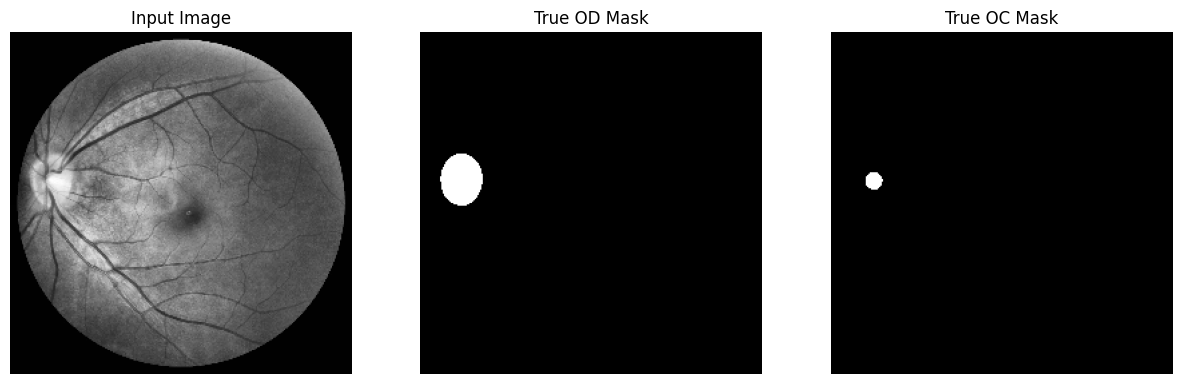

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True OD Mask', 'True OC Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

display([img[0], msk_OD, msk_OC])

In [ ]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice


[Text(0.5, 1.0, 'OC segmentation')]

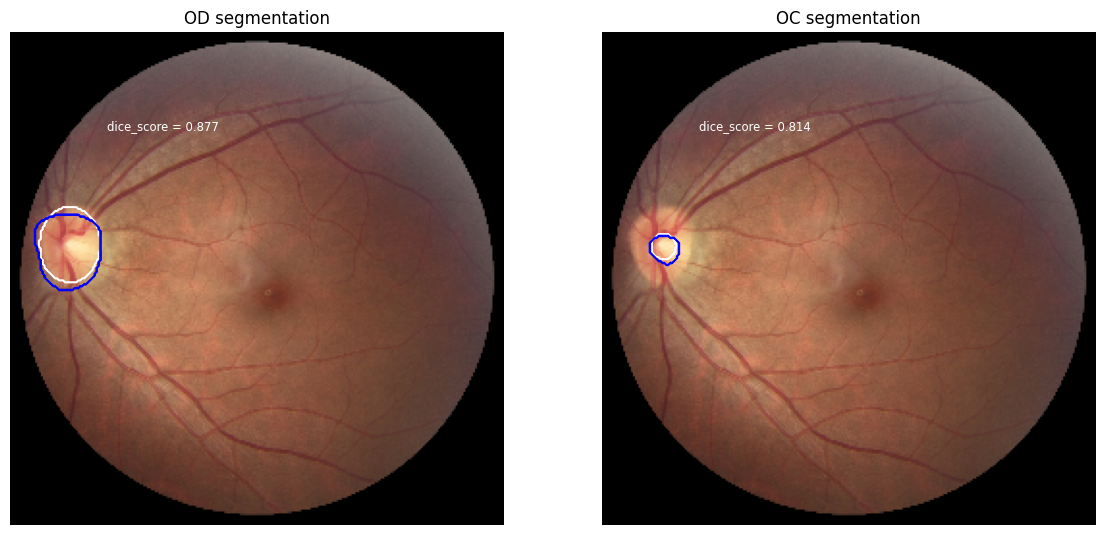

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize= (14, 7))
ax[0].imshow(img_t[0])
ax[0].contour(np.squeeze(msk_OD), colors='w')
ax[0].contour(np.squeeze(pred_mask_OD[0]), colors='b', linewidths=0.5)
ax[0].text(50, 50, 'dice_score = {}'.format(round(dice(pred_mask_OD[0]/255, msk_OD), 3)), fontsize='small', color ='w')
ax[0].grid(False)
ax[0].axis(False)
ax[0].set(title='OD segmentation')

ax[1].imshow(img_t[0])
ax[1].contour(np.squeeze(msk_OC), colors='w')
ax[1].contour(np.squeeze(pred_mask_OC[0]), colors='b', linewidths=0.5)
ax[1].text(50, 50, 'dice_score = {}'.format(round(dice(pred_mask_OC[0]/255, msk_OC), 3)), fontsize='small', color ='w')
ax[1].grid(False)
ax[1].axis(False)
ax[1].set(title='OC segmentation')

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()

model.load_model('/content/gdrive/MyDrive/MiniProjectDataset/classifier_model.h5')

In [ ]:
def CDRcalc(OD_feat, OC_feat):
  VCDR = float(OC_feat[0]) / float(OD_feat[0]) # vertical CDR
  HCDR = float(OC_feat[1]) / float(OD_feat[1]) # Horizontal CDR
  ACDR = float(OC_feat[2]) / float(OD_feat[2]) # Area CDR

  return VCDR, HCDR, ACDR

def getFeature(mask):
  cont, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  cont = cv2.approxPolyDP(cont[0], 3, True)
  _, _, hor, ver = cv2.boundingRect(cont)
  area = np.sum(mask == 255)

  return ver, hor, area

In [ ]:
OD_feat=getFeature((pred_mask_OD[0]).astype(np.uint8))
OC_feat=getFeature((pred_mask_OC[0]).astype(np.uint8))
V, H, A=CDRcalc(OD_feat, OC_feat)
X_test=[[V, H, A]]

In [ ]:
y_pred=model.predict(X_test)

if(y_pred):
  print('Eye is glaucomatous')
else:
  print('Eye is not glaucomatous')

Eye is not glaucomatous
